###### Process Optimization of Photonic Curing for Perovskites on Willow Glass

### Batch 2 Data Analysis 

Zhe Liu, Ph.D. 
Northwestern Polytechnical University (NPU), Xi'an, P.R. China

In collaboration with Julia Hsu, Weijie Xu and Robert Piper at UT Dallas

V1.0 - 2021.11.01

Install Anaconda and open this notebook in Jupyter

Requires Emukit package and its dependent packages (pyDOE, GPy, etc.)

    e.g. pip intall emukit (maybe, pip install pyDOE)

Experimental information:
Batch 0: LHS batch is 16 experimental conditions 
Batch 1: acquisition batch is 8 experimental conditions from BO and 8 from LHS in the unknown region
    - Upper bound for PC length was extended to 100 ms. 
Batch 2: acquisition batch is 16 experimental conditions from BO
    - Resolution (or step) of MAPbI3 concentration to 0.05 M
    - Resolution (or step) of CH2I2 concentration to 5 uL
    - Lower bound for MAPbI3 concentration was extended to 1.2

Samples: 6 pixel cells per substrate, and 2 duplicates per condition

Parameter resolution (Finest grid we are able to/are willing to tune). 
- Molar Concentration MAPbI3 - 0.05 M
- Addition of CH2I2 - 5 uL
- PC voltage - no limit (willing to tune 1 V)
- PC pulse-length - no limit (willing to tune 0.1 ms)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Find out the experimental noises in the data

In [2]:
df_data = pd.read_excel('Group2_run1&2&3_J-V_Data.xlsx').iloc[:218,:14]
df_data= df_data.sort_values(by=list(df_data.iloc[:,[0,-3]].columns))
std_dev_list = []
for c in range(31,int(max(df_data['Condition']+1))):
    eff_list_r1 = df_data[np.logical_and(df_data['Condition'] == c, df_data['Run'] == 1.0)].iloc[:,-3].values
    eff_list_r2 = df_data[np.logical_and(df_data['Condition'] == c, df_data['Run'] == 2.0)].iloc[:,-3].values
    eff_list = df_data[df_data['Condition'] == c].iloc[:,-3].values
    r = 0
    for eff_list_i in [eff_list_r1, eff_list_r2]:
        r = r +1 
        if len(eff_list_i)>1:
            std_dev = np.std(eff_list_i)
        elif len(eff_list_i)==1:
            std_dev = 0.0
        else:
            eff_list_i = np.append(eff_list_i, 0.0)
            std_dev = 0.0

        print('cond.',c, 'run', r, 'tot. num.', len(eff_list_i),' med. eff:', np.around(eff_list_i[-1],2), 'std_dev:', np.around(std_dev,2))


        std_dev_list.append([c, std_dev])

print('mean std_dev:', np.around(np.mean(np.array(std_dev_list)[np.array(std_dev_list)[:,-1]!=0.0][:,-1]),2))
# df_data[df_data['Condition'] == 6]

# #find Q1, Q3, and interquartile range for each column
# Q1 = data.quantile(q=.25)
# Q3 = data.quantile(q=.75)
# IQR = data.apply(stats.iqr)

# #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
# data_clean = data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR))).any(axis=1)]

cond. 31 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 31 run 2 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 32 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 32 run 2 tot. num. 8  med. eff: 8.47 std_dev: 0.4
cond. 33 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 33 run 2 tot. num. 4  med. eff: 8.73 std_dev: 0.18
cond. 34 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 34 run 2 tot. num. 8  med. eff: 8.44 std_dev: 0.4
cond. 35 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 35 run 2 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 36 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 36 run 2 tot. num. 6  med. eff: 10.18 std_dev: 0.76
cond. 37 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 37 run 2 tot. num. 6  med. eff: 9.8 std_dev: 0.62
cond. 38 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 38 run 2 tot. num. 4  med. eff: 9.48 std_dev: 0.68
cond. 39 run 1 tot. num. 8  med. eff: 10.09 std_dev: 0.87
cond. 39 run 2 tot. num. 1  med. eff: 0.0 std_dev: 0

### Preprocessing the data for the regression model

In [3]:
df_data = pd.read_excel('./Group0_run1&2_J-V_Data_BM.xlsx')
df_data = df_data.iloc[:158,:16]
df_data

,Condition,MAPbI Conc [M],CH2I2 Conc [uL],Final Conc [M],PC voltage [V],PC length [ms],Sample,Diode,Voc [V],Jsc [mA/cm2],FF,PCE [%],Scan Direction,Run,Unnamed: 14
0,0,1.6,150,1.319626,433,18.3,0,1,0.000,0.00,0.000,0.00,F,1,NaN
1,1,1.5,50,1.400794,222,17.1,1,1,0.928,1.96,0.405,0.74,F,1,NaN
2,1,1.5,50,1.400794,222,17.1,1,2,0.935,2.02,0.435,0.82,F,1,NaN
3,1,1.5,50,1.400794,222,17.1,1,3,0.538,2.15,0.344,0.40,F,1,NaN
4,1,1.5,50,1.400794,222,17.1,1,5,0.615,2.21,0.349,0.47,F,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,15,1.4,150,1.154673,290,20.0,15,2,0.977,15.85,0.688,10.66,F,1,NaN
135,15,1.4,150,1.154673,290,20.0,15,3,0.984,15.42,0.692,10.51,F,1,NaN
136,15,1.4,150,1.154673,290,20.0,15,1,0.984,15.86,0.732,11.42,R,1,NaN
137,15,1.4,150,1.154673,290,20.0,15,2,0.977,15.86,0.692,10.73,R,1,NaN


In [4]:
df_data = pd.read_excel('./Group0_run1&2_J-V_Data_BM.xlsx')
#df_data = df_data[np.logical_or(df_data['Scan Direction'] == 0, df_data['Scan Direction'] == 'F
df_data = df_data.iloc[:158,:14]
#df_data = df_data.drop(columns = ['PCE Standard Deviation (per run, %)'])
df_data = df_data.sort_values(by=list(df_data.iloc[:,[0,11]].columns)).drop_duplicates('Condition', 
                                                                                        keep = 'last', 
                                                                                        ignore_index = True)
df_batch0 = df_data
print('batch 0:', len(df_batch0))

df_data = pd.read_excel('./Group1_run1&2_J-V_Data.xlsx')
df_data = df_data.iloc[:108,:14]
df_data['Condition'] = df_data['Condition']+16
#df_data = df_data.drop(columns = ['PCE Standard Deviation (per run, %)'])
#df_data = df_data[np.logical_or(df_data['Scan Direction'] == 0, df_data['Scan Direction'] == 'F')]
df_data = df_data.sort_values(by=list(df_data.iloc[:,[0,11]].columns)).drop_duplicates('Condition', 
                                                                                        keep = 'last', 
                                                                                        ignore_index = True)
df_batch1 = df_data
print('batch 1:', len(df_batch1))

df_data = pd.read_excel('./Group2_run1&2&3_J-V_Data.xlsx')
df_data = df_data.iloc[:216,:14]
#df_data = df_data.drop(columns = ['PCE Standard Deviation (per run, %)'])
#df_data = df_data[np.logical_or(df_data['Scan Direction'] == 0, df_data['Scan Direction'] == 'F')]
df_data = df_data.sort_values(by=list(df_data.iloc[:,[0,11]].columns)).drop_duplicates('Condition', 
                                                                                        keep = 'last', 
                                                                                        ignore_index = True)
df_batch2 = df_data
print('batch 2:', len(df_batch2))


df_data = pd.concat([df_batch0, df_batch1,df_batch2], ignore_index = True)
df_data

batch 0: 16
batch 1: 16
batch 2: 16


,Condition,MAPbI Conc [M],CH2I2 Conc [uL],Final Conc [M],PC voltage [V],PC length [ms],Sample,Diode,Voc [V],Jsc [mA/cm2],FF,PCE [%],Scan Direction,Run
0,0,1.60,150,1.319626,433,18.3,0,1.0,0.000,0.00,0.000,0.00,F,1.0
1,1,1.50,50,1.400794,222,17.1,1,2.0,0.907,2.15,0.520,1.02,R,1.0
2,2,1.50,100,1.313896,373,6.3,2,2.0,0.768,16.03,0.622,7.66,F,1.0
3,3,1.30,100,1.138710,252,11.1,3,4.0,0.712,2.69,0.456,0.87,F,1.0
4,4,1.60,100,1.401489,237,9.9,4,4.0,0.859,1.59,0.507,0.69,F,1.0
5,5,1.50,50,1.400794,358,12.3,5,3.0,0.476,17.20,0.413,3.38,F,2.0
6,6,1.40,0,1.400000,312,15.9,6,2.0,0.845,13.63,0.536,6.17,R,1.0
7,7,1.50,250,1.107741,328,19.5,7,1.0,0.991,16.59,0.656,10.78,F,2.0
8,8,1.60,200,1.246799,297,2.7,8,3.0,0.928,6.82,0.595,3.77,F,2.0
9,9,1.40,200,1.090949,267,7.5,9,6.0,0.935,4.08,0.498,1.90,F,1.0


In [5]:
df = df_data.iloc[:48,[1,2,4,5,8,9,10,11]]
df.columns = ['MAPbI Conc [M]', "CH₂I₂ Conc [μL]", "PC voltage [V]", 
              'PC length [ms]', 'Voc [V]', 'Jsc [mA/cm²]','FF [%]','PCE [%]']
for i in np.arange(len(df)):
    if df['PCE [%]'].values[i] == 0:
        df.iloc[i,7]=0.5
    if df['PCE [%]'].values[i] == 'bad':
        df.iloc[i,7]=0.5

df

,MAPbI Conc [M],CH₂I₂ Conc [μL],PC voltage [V],PC length [ms],Voc [V],Jsc [mA/cm²],FF [%],PCE [%]
0,1.60,150,433,18.3,0.000,0.00,0.000,0.50
1,1.50,50,222,17.1,0.907,2.15,0.520,1.02
2,1.50,100,373,6.3,0.768,16.03,0.622,7.66
3,1.30,100,252,11.1,0.712,2.69,0.456,0.87
4,1.60,100,237,9.9,0.859,1.59,0.507,0.69
5,1.50,50,358,12.3,0.476,17.20,0.413,3.38
6,1.40,0,312,15.9,0.845,13.63,0.536,6.17
7,1.50,250,328,19.5,0.991,16.59,0.656,10.78
8,1.60,200,297,2.7,0.928,6.82,0.595,3.77
9,1.40,200,267,7.5,0.935,4.08,0.498,1.90


### Define the parameter space

In [6]:
import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

In [7]:
MAPbI_conc_min, MAPbI_conc_max, MAPbI_conc_step = [1.2, 1.6, 0.05]  # Unit: V 
### Give step a scaling factor of 0.1 to avoid numercial errors such as 1.7000002
MAPbI_conc_var = np.arange(MAPbI_conc_min, MAPbI_conc_max+MAPbI_conc_step*0.1, MAPbI_conc_step)
MAPbI_conc_num = len(MAPbI_conc_var)

CH2I2_conc_min, CH2I2_conc_max, CH2I2_conc_step = [0, 250, 5] ## Unit: μL
CH2I2_conc_var = np.arange(CH2I2_conc_min, CH2I2_conc_max+CH2I2_conc_step*0.1, CH2I2_conc_step)
CH2I2_conc_num = len(CH2I2_conc_var)

PC_volt_min, PC_volt_max, PC_volt_step = [200, 440, 1] ## Unit: V
PC_volt_var = np.arange(PC_volt_min, PC_volt_max+PC_volt_step*0.1, PC_volt_step) 
PC_volt_num = len(PC_volt_var)

PC_len_min, PC_len_max, PC_len_step = [1, 100, 0.1]  ## Unit: ms
PC_len_var = np.arange(PC_len_min, PC_len_max+PC_len_step*0.1, PC_len_step)
PC_len_num = len(PC_len_var)

var_array = [MAPbI_conc_var,
             CH2I2_conc_var, 
             PC_volt_var, 
             PC_len_var]

x_labels =  ["MAPbI Conc [M]",
             "CH₂I₂ Conc [μL]",
             "PC voltage [V]", 
             "PC length [ms]"]

def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
        x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [8]:
parameter_space = ParameterSpace([ContinuousParameter('MAPbI_conc', 0-1/(MAPbI_conc_num-1)/2, 1+1/(MAPbI_conc_num-1)/2),
                                  ContinuousParameter('CH2I2_conc', 0-1/(CH2I2_conc_num-1)/2, 1+1/(CH2I2_conc_num-1)/2),
                                  ContinuousParameter('PC_volt', 0-1/(PC_volt_num-1)/2, 1+1/(PC_volt_num-1)/2),
                                  ContinuousParameter('PC_len', 0-1/(PC_len_num-1)/2, 1+1/(PC_len_num-1)/2),
                                  ])


### Build a GP regression model 

In [9]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_exp = x_normalizer(df.iloc[:,0:4].values)
y_exp = np.transpose([df.iloc[:,-1].values])
X, Y = [x_exp, y_exp]

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#

ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
model_gpy = GPRegression(X, -Y, ker) #Emukit is a minimization tool; need to make Y negative
model_gpy.Gaussian_noise.variance = 0.5**2
model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)
print(model_gpy)
print(objective_model.model.kern.lengthscale)
print(objective_model.model.kern.variance)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance



Name : GP regression
Objective : 103.47612547258593
Number of Parameters : 6
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  Mat52.variance           |  25.1691488442842  |  0.1,1000.0   |        
  Mat52.lengthscale        |              (4,)  |    0.1,1.0    |        
  Gaussian_noise.variance  |              0.25  |   +ve fixed   |        
  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       1.00000000  |    0.1,1.0    |        
  [1]    |                       1.00000000  |    0.1,1.0    |        
  [2]    |                       0.16646825  |    0.1,1.0    |        
  [3]    |                       0.10403568  |    0.1,1.0    |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                   25.16914884  |  0.1,1000.0   |        


MAE: 0.13   RMSE: 0.18   spearman: 0.991   R² score: 0.998


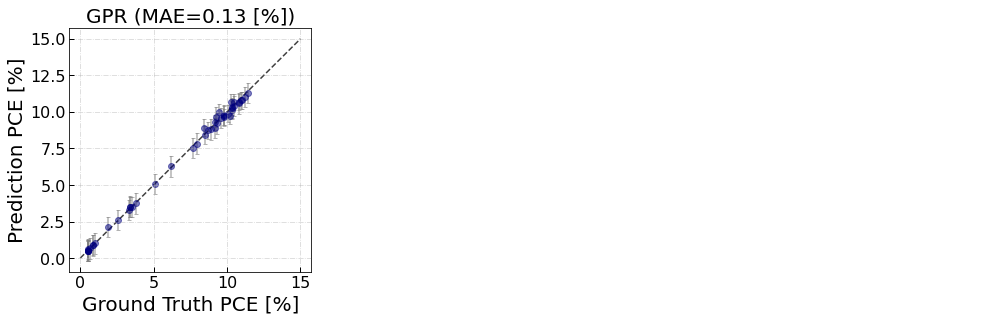

In [10]:
f_obj =  objective_model.model.predict
y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
lims1 = (0, 15)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
mae_value = mean_absolute_error(Y[:,-1], y_pred)
spearman_value = spearmanr(Y[:,-1], y_pred)[0]
rsquared_value = r2_score(Y[:,-1], y_pred)

print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth PCE [%]', fontsize = fs)
axes[0].set_ylabel('Prediction PCE [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

axes[1].axis("off")
axes[2].axis("off")

plt.show()



### Run BO to get  suggestions of new experimental conditons

In [11]:

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

np.random.seed(1000)#to make sure the random results is reproducible 
bs = 16

# ## Expeceted Improvement (EI)
## acquisition = ExpectedImprovement(objective_model, jitter=.1)
# ## Uppper Confidence Bound (UCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
# ## Maximum Value Entropy Search (MES)
# acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*4)

# Make loop and collect points
bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)
                                   #batchsize may need to be >bs due to duplication

print('total condition no.:', len(X))
print('total device no.:', len(bayesopt.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = x_labels)
df_all = pd.concat([df.iloc[:,0:4], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df):len(df)+bs]
df_Xnew = df_Xnew.sort_values(by=list(df.columns[0:4]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df)
print('New X:',len(df_Xnew))
df_Xnew


total condition no.: 48
total device no.: 48
maximum Y (PCE [%]):  11.42


 /Users/JeremyXu/opt/anaconda3/lib/python3.8/site-packages/emukit/bayesian_optimization/acquisitions/log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


New X: 14


,MAPbI Conc [M],CH₂I₂ Conc [μL],PC voltage [V],PC length [ms]
48,1.40,235.0,250.0,6.3
49,1.40,250.0,249.0,5.9
50,1.45,225.0,313.0,25.0
51,1.45,240.0,313.0,25.1
52,1.45,250.0,313.0,25.1
53,1.50,220.0,312.0,25.0
54,1.50,225.0,312.0,24.9
55,1.50,225.0,312.0,25.0
56,1.50,235.0,307.0,24.4
57,1.50,235.0,313.0,25.0


### Quick histogram visualization of the newly suggested process conditions

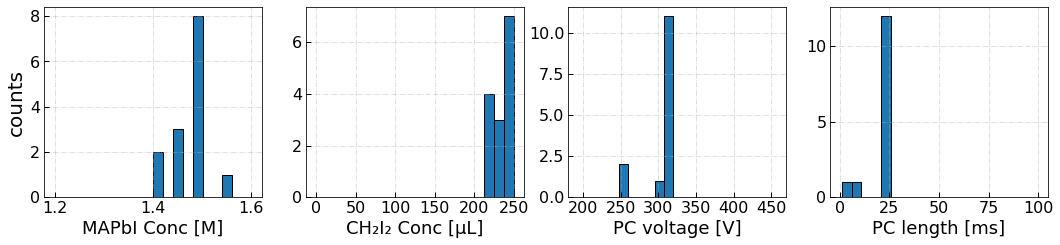

In [12]:
df_x = df_Xnew
df_cols = df.columns
n_col = 4 # num of columns per row in the figure
fs = 20
for n in np.arange(0, 4, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df_x.iloc[:,n], bins= 20, range = (min(var_array[n])- 0.05*abs(var_array[n][1]-var_array[n][0]),
                                                            max(var_array[n])+0.05*abs(var_array[n][1]-var_array[n][0])), 
                         edgecolor='black') ####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
            if i==1:#MAPbI
                axes[i].set_xticks([0, 50, 100, 150, 200, 250])
            
            if i==2:#PC voltage
                axes[i].set_xticks([200, 250, 300, 350, 400, 450])
                axes[i].set_xlim(180,470)
                
            if i==3:#PC length
                axes[i].set_xticks([0, 25, 50, 75, 100])
                axes[i].set_xlim(-5,105)


        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = fs)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

### Visualisation of Efficiency vs ML conditions, and Acquisition

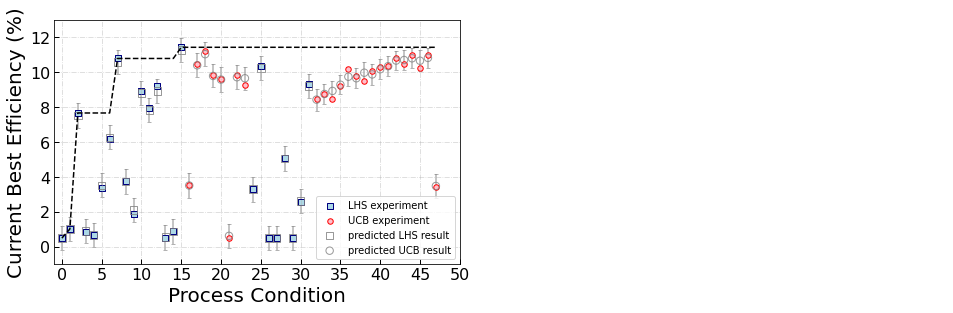

In [75]:
device_lhs_eff=np.append(df.iloc[0:16,7].values,df.iloc[24:32,7].values)
device_lhs_eff
device_ucb_eff=np.append(df.iloc[16:24,7].values,df.iloc[32:48,7].values)
device_ucb_eff
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey = False)
fs = 20
exp_lhs_cond = np.append(np.arange(16),np.arange(24,32))
exp_ucb_cond = np.append(np.arange(16,24),np.arange(32,48))
exp_lhs_eff = np.transpose(device_lhs_eff)
exp_ucb_eff = np.transpose(device_ucb_eff)

axes[0].scatter(exp_lhs_cond, exp_lhs_eff, facecolor = 'lightblue',
            marker = 's', edgecolor = 'navy', s = 30, alpha = 1, label = 'LHS experiment')
axes[0].scatter(exp_ucb_cond, exp_ucb_eff, facecolor = 'pink',
            marker = 'o', edgecolor = 'red', s = 30, alpha = 1, label = 'UCB experiment')

axes[0].plot(np.transpose(exp_cond), np.maximum.accumulate(np.transpose(exp_eff)), 
         marker = 'o', ms = 0, c = 'black',linestyle='--')

axes[0].scatter(exp_lhs_cond, np.append(y_pred[0:16],y_pred[24:32]),
                marker = 's', s = 55, facecolors='none', alpha = 0.8, edgecolor = 'gray', label = 'predicted LHS result')
axes[0].scatter(exp_ucb_cond, np.append(y_pred[16:24],y_pred[32:48]),
                marker = 'o', s = 55, facecolors='none', alpha = 0.8, edgecolor = 'gray', label = 'predicted UCB result')

axes[0].errorbar(exp_cond, y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)

axes[0].set_ylabel('Current Best Efficiency (%)', fontsize = 20)
axes[0].set_xlabel('Process Condition', fontsize = 20)

axes[0].set_ylim(-1, 13)
axes[0].set_xlim(-1, 50)
axes[0].set_xticks(np.arange(0,55,5))
axes[0].legend(fontsize = fs*0.5, loc = 'lower right')

axes[1].axis("off")
for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.2)

plt.show()

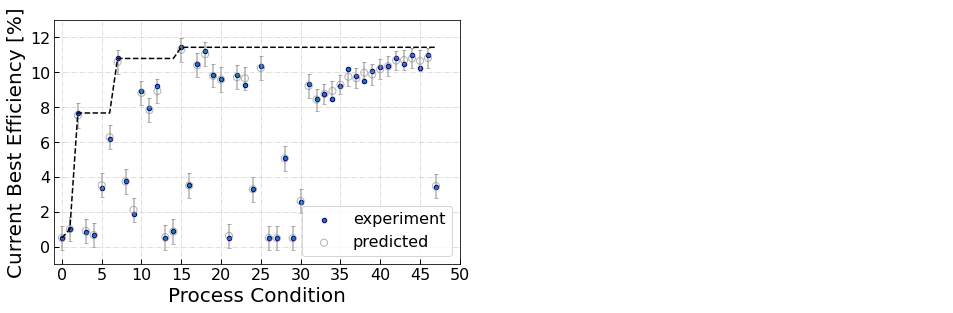

In [76]:
#f_obj =  objective_model.model.predict       
device_eff = df.iloc[:,7].values
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey = False)
fs = 20
exp_cond = np.arange(len(device_eff))
exp_eff = np.transpose(device_eff)

axes[0].scatter(exp_cond, exp_eff, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 1, label = 'experiment')

axes[0].plot(np.transpose(exp_cond), np.maximum.accumulate(np.transpose(exp_eff)), 
         marker = 'o', ms = 0, c = 'black',linestyle='--')

axes[0].scatter(np.arange(len(X)), y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[0].errorbar(np.arange(len(X)), y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

#axes[0].scatter(np.arange(len(df_Xnew))+len(X), y_pred_new,
#               s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
#axes[0].errorbar(np.arange(len(df_Xnew))+len(X), y_pred_new, yerr = y_uncer_new,  
#                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
#                 color = 'darkgreen', zorder = 0)


axes[0].set_ylabel('Current Best Efficiency [%]', fontsize = 20)
axes[0].set_xlabel('Process Condition', fontsize = 20)

axes[0].set_ylim(-1, 13)
axes[0].set_xlim(-1, 50)
axes[0].set_xticks(np.arange(0,55,5))
axes[0].legend(fontsize = fs*0.8)

axes[1].axis("off")
for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.2)

plt.show()

### Partial Dependence Plot 
#####  Two-varible contour map (with randomly sampling in the other two variables)

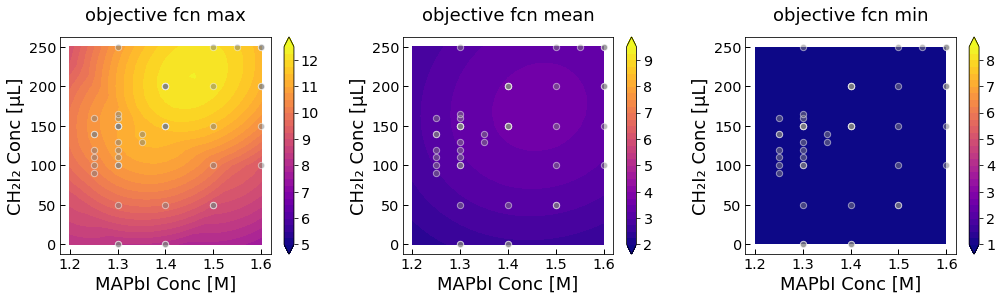

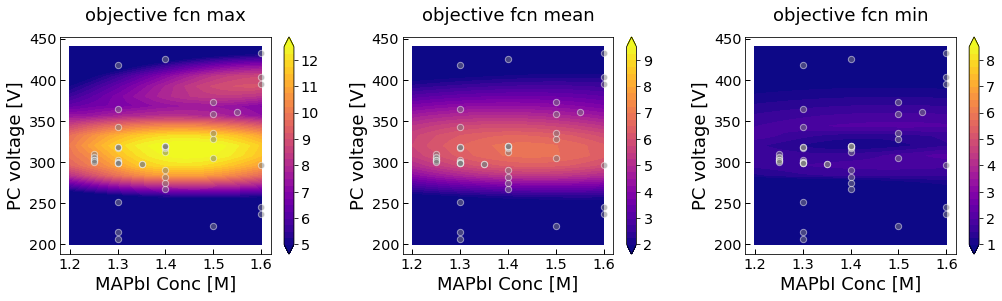

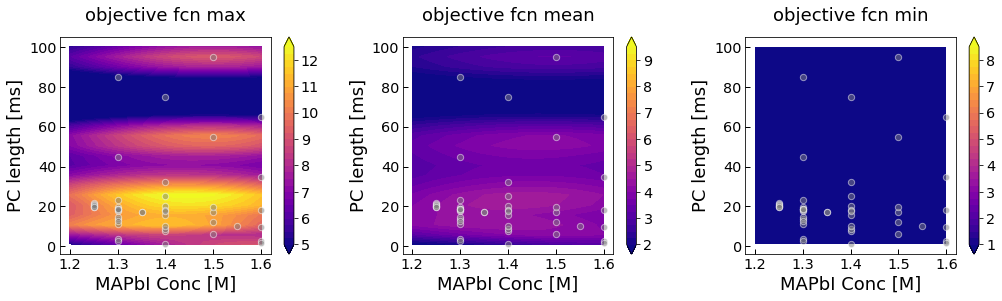

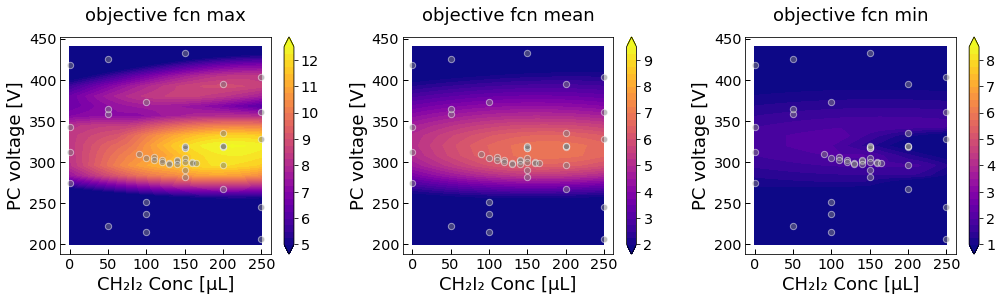

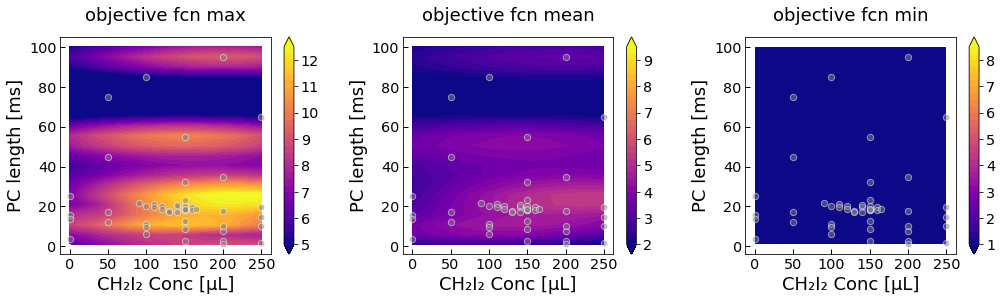

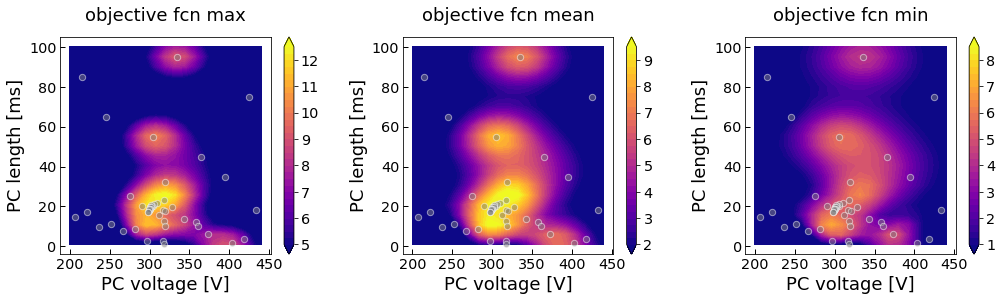

In [79]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:4].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred 
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [5, 2, 1]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):#[y_pred_max, y_pred_mean, y_pred_min]
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(31)*0.25+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')

#            ax.scatter(df_Xnew.values[:, ind1], 
#                       df_Xnew.values[:, ind2], 
#                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MAPbI3
                ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6])
            if ind1==1:#CH2I2
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()


#### Partial Contours of Acquisition Functions

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:4].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.0]
        norm = 16
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/norm, levels = np.arange(16)*0.025+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')
            ax.scatter(df_Xnew.values[:, ind1], 
                       df_Xnew.values[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:#MAPbI3
                ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6])
            if ind1==1:#CH2I2
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])
            
        axes[0].set_title('acqui fcn max', pad = title_pad,fontsize = fs)
        axes[1].set_title('acqui fcn mean', pad = title_pad,fontsize = fs)
        axes[2].set_title('acqui fcn min', pad = title_pad,fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(5.5*4, 4.5))
fs = 22

for i in np.arange(4):
    max_min = (np.max(df.iloc[:, i].values)-np.min(df.iloc[:, i].values))
    axes[i].hist(np.array(df.iloc[:, i].values), bins =10, width = 0.05*max_min, alpha = 0.7)
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
    axes[i].set_xlabel('Values', fontsize = fs)
    axes[i].set_ylabel('Counts', fontsize = fs)
    axes[i].set_title('Raw X'+str(i+1), fontsize = fs)
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(5.5*4, 4.5))
fs = 22

for i in np.arange(4):
    axes[i].hist(np.array(X[:, i]), bins =10, width = 0.05, alpha = 0.7, color = 'orange')
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
    axes[i].set_xlabel('Values', fontsize = fs)
    axes[i].set_ylabel('Counts', fontsize = fs)
    axes[i].set_title('Norm. X'+str(i+1), fontsize = fs)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
#scalerY= StandardScaler() 
scalerY = QuantileTransformer(n_quantiles = 48)
y_norm =  scalerY.fit_transform(Y)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
fs = 20

ax = axes[0]
ax.hist(np.array(Y), bins =15, width = 0.5, alpha = 0.5, color = 'green')
ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
ax.grid(True, linestyle='-.')
ax.set_title('Raw y', fontsize = fs)
ax.set_xlabel('Values', fontsize = fs)
ax.set_ylabel('Counts', fontsize = fs)


ax = axes[1]
ax.hist(np.array(y_norm), bins =15, width = 0.05, alpha = 0.5, color = 'olive')
ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
ax.grid(True, linestyle='-.')
ax.set_title('Normalized y', fontsize = fs)
ax.set_xlabel('Values', fontsize = fs)
ax.set_ylabel('Counts', fontsize = fs)

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from scipy.stats import spearmanr as spr

def plt_true_vs_pred (y_true_list, y_pred_list, title_str_list, color_list):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    for i in np.arange(len(axes)):
        ## inverse transform 
        y_true = y_true_list[i]
        y_pred = y_pred_list[i]
        

        lims1 = (0*0.9, 5000*1.1)
        axes[i].scatter(y_true, y_pred, alpha = 0.6, c = color_list[i])
        axes[i].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
        rmse_value = np.sqrt(mse(y_true, y_pred))
        mae_value = mae(y_true, y_pred)
        mape_value = mape(y_true, y_pred)
        spearman_value = spr(y_true, y_pred)[0]
        
        print(title_str_list[i],'RMSE:', np.around(rmse_value,3))
        print(title_str_list[i],'MAE:',  np.around(mae_value,3))
        print(title_str_list[i],'MAPE:',  np.around(mape_value,3))
        print(title_str_list[i],'spearman coeff.:',  np.around(spearman_value,3))


        title = title_str_list[i] + " (SPRMan=%.2f" % spearman_value+')'
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_title(title, fontsize = fs)
        axes[i].set_xlim(0,15)
        axes[i].set_ylim(0,15)
        #axes[i].set_yscale('log')
        #axes[i].set_xscale('log')

        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')

        
    plt.subplots_adjust(wspace = 0.4)
    plt.show()

### Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_train =  lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)


y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))


In [ ]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['Linear - Train','Linear -  Test'],
                 ['blue', 'darkorange'])

### Polynormial Regression 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

poly_feat = PolynomialFeatures(degree=2)
X_poly_train = poly_feat.fit_transform(X_train)
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)
y_pred_train = poly_reg.predict(X_poly_train)
y_pred_test = poly_reg.predict(poly_feat.fit_transform(X_test))

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

PolyN - Train RMSE: 1.614
PolyN - Train MAE: 0.932
PolyN - Train MAPE: 0.24
PolyN - Train spearman coeff.: 0.91
PolyN -  Test RMSE: 4.594
PolyN -  Test MAE: 3.057
PolyN -  Test MAPE: 2.569
PolyN -  Test spearman coeff.: 0.429


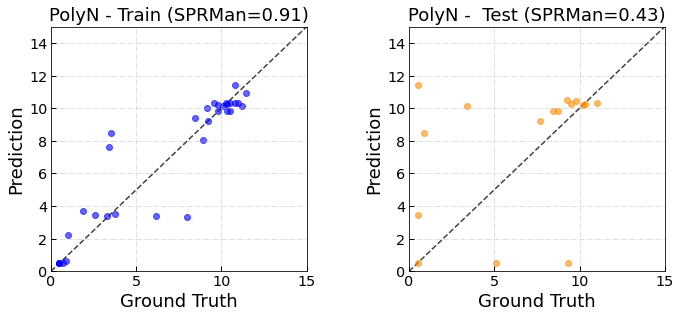

In [22]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['PolyN - Train','PolyN -  Test'],
                 ['blue', 'darkorange'])

### Random Forest Regression 

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=21)

rf_regr = RandomForestRegressor(n_estimators=100, max_depth = 5)# criterion="squared_error",'absolute_error'
rf_regr.fit(X_train,y_train.ravel())
y_pred_train = rf_regr.predict(X_train)
y_pred_test = rf_regr.predict(X_test)


y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

RFR - Train RMSE: 1.256
RFR - Train MAE: 0.713
RFR - Train MAPE: 0.344
RFR - Train spearman coeff.: 0.98
RFR -  Test RMSE: 3.957
RFR -  Test MAE: 2.666
RFR -  Test MAPE: 2.689
RFR -  Test spearman coeff.: 0.648


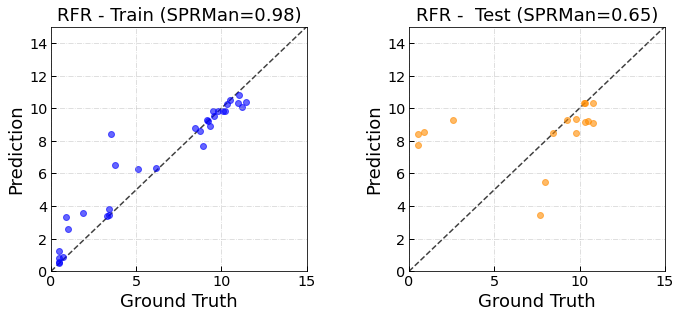

In [24]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['RFR - Train','RFR -  Test'],
                 ['blue', 'darkorange'])

### Gradient Boosting Regression 

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

gb_regr = GradientBoostingRegressor(n_estimators=30, max_depth = 3)#{‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}
gb_regr.fit(X_train,y_train.ravel())
y_pred_train = gb_regr.predict(X_train)
y_pred_test = gb_regr.predict(X_test)

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

GBDT - Train RMSE: 1.046
GBDT - Train MAE: 0.569
GBDT - Train MAPE: 0.201
GBDT - Train spearman coeff.: 0.977
GBDT -  Test RMSE: 3.276
GBDT -  Test MAE: 2.087
GBDT -  Test MAPE: 1.737
GBDT -  Test spearman coeff.: 0.824


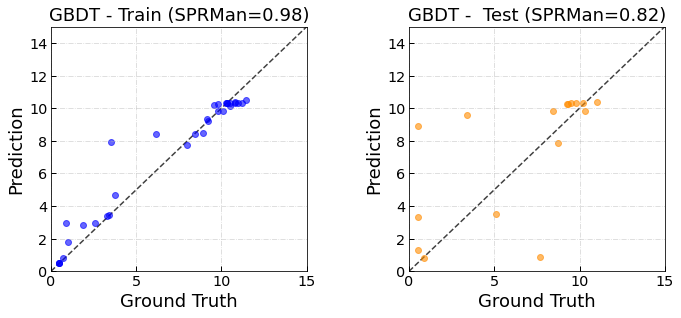

In [26]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['GBDT - Train','GBDT -  Test'],
                 ['blue', 'darkorange'])

### Neural Network Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

NN_regr = MLPRegressor(hidden_layer_sizes = [56, 56, 56], alpha = 0.01, activation = 'relu',
                         max_iter = 2000, solver='adam',verbose=False,
                         tol=1e-8)
NN_regr.fit(X_train,y_train.ravel())
y_pred_train = NN_regr.predict(X_train)
y_pred_test = NN_regr.predict(X_test)

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))


 /Users/JeremyXu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.


NN - Train RMSE: 0.209
NN - Train MAE: 0.117
NN - Train MAPE: 0.031
NN - Train spearman coeff.: 0.994
NN -  Test RMSE: 3.781
NN -  Test MAE: 2.316
NN -  Test MAPE: 2.558
NN -  Test spearman coeff.: 0.513


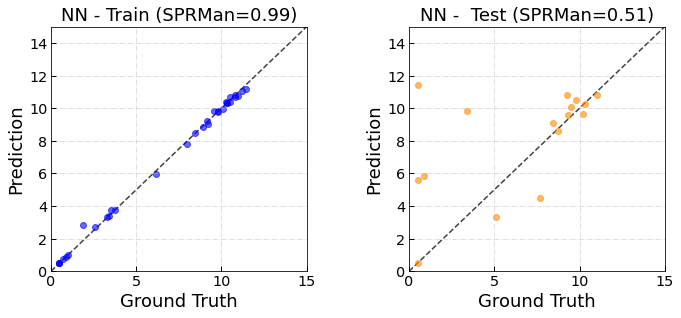

In [30]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['NN - Train','NN -  Test'],
                 ['blue', 'darkorange'])

### Gaussian Process Regression

In [31]:
import GPy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

ker = GPy.kern.Matern52(input_dim = 4, ARD =True)#
ker.lengthscale.constrain_bounded(1e-2, 1)
ker.variance.constrain_bounded(1e-2, 100.0)
gpy_regr = GPRegression(X_train,y_train, ker)#Emukit is a minimization tool; need to make Y negative
# gpy_regr.Gaussian_noise.variance = (0.5)**2
# gpy_regr.Gaussian_noise.variance.fix()
gpy_regr.randomize()
gpy_regr.optimize_restarts(num_restarts=20,verbose =False, messages=False)
print(ker.lengthscale)
print(ker.variance)
print(gpy_regr.Gaussian_noise)


y_pred_train, y_uncer_train= gpy_regr.predict(X_train)
y_pred_test, y_uncer_test = gpy_regr.predict(X_test)

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       0.66796282  |   0.01,1.0    |        
  [1]    |                       0.66009948  |   0.01,1.0    |        
  [2]    |                       0.43818611  |   0.01,1.0    |        
  [3]    |                       0.17110991  |   0.01,1.0    |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                    0.14547049  |  0.01,100.0   |        
  Gaussian_noise.  |                 value  |  constraints  |  priors
  variance         |  0.003879234641546586  |      +ve      |        


GP - Train RMSE: 0.303
GP - Train MAE: 0.168
GP - Train MAPE: 0.042
GP - Train spearman coeff.: 0.993
GP -  Test RMSE: 3.466
GP -  Test MAE: 2.409
GP -  Test MAPE: 1.571
GP -  Test spearman coeff.: 0.677


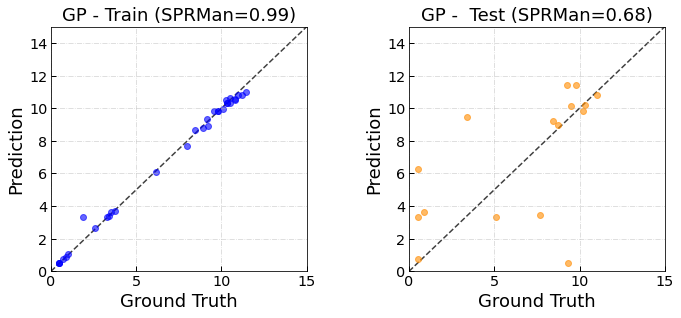

In [32]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['GP - Train','GP -  Test'],
                 ['blue', 'darkorange'])

### Ensemble of many regression models 

#### Linear Ensemble 

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=1)

def regr_pred(regr_list, X):
    y_regr_pred = []
    i = 0
    for regr in regr_list:
        y_regr_pred.append(scalerY.inverse_transform(regr(X).reshape(-1,1)).ravel())
    return np.array(y_regr_pred)

def gpy_regr_predict(X, gpy_regr = gpy_regr):
    yc_pred, yc_uncer= gpy_regr.predict(X)
    return yc_pred.ravel()

regr_list = [NN_regr.predict, gb_regr.predict, rf_regr.predict, gpy_regr_predict]
lin_reg = LinearRegression()
lin_reg.fit(np.transpose(regr_pred(regr_list, X_train)), y_train.ravel())
y_pred_train = lin_reg.predict(np.transpose(regr_pred(regr_list, X_train)))
y_pred_test = lin_reg.predict(np.transpose(regr_pred(regr_list, X_test)))

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

Lin Ensem - Train RMSE: 0.563
Lin Ensem - Train MAE: 0.431
Lin Ensem - Train MAPE: 0.11
Lin Ensem - Train spearman coeff.: 0.989
Lin Ensem -  Test RMSE: 4.876
Lin Ensem -  Test MAE: 2.991
Lin Ensem -  Test MAPE: 3.54
Lin Ensem -  Test spearman coeff.: -0.01


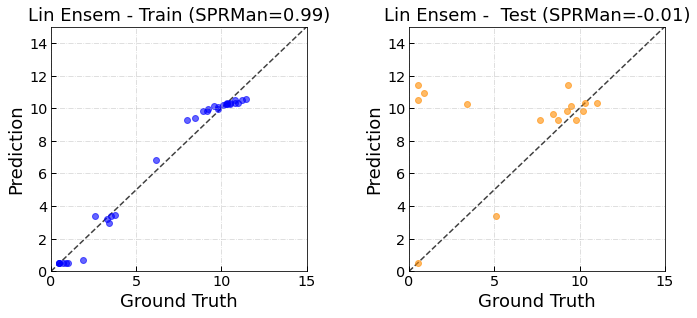

In [34]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['Lin Ensem - Train','Lin Ensem -  Test'],
                 ['blue', 'darkorange'])

#### Random Forest Ensemble 

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.33, random_state=21)

def regr_pred(regr_list, X):
    y_regr_pred = []
    i = 0
    for regr in regr_list:
        y_regr_pred.append(scalerY.inverse_transform(regr(X).reshape(-1,1)).ravel())
    return np.array(y_regr_pred)

def gpy_regr_predict(X, gpy_regr = gpy_regr):
    yc_pred, yc_uncer= gpy_regr.predict(X)
    return yc_pred.ravel()

regr_list = [NN_regr.predict, gb_regr.predict, rf_regr.predict, gpy_regr_predict]
rfr_reg = RandomForestRegressor(n_estimators=30, max_depth = 3)
rfr_reg.fit(np.transpose(regr_pred(regr_list, X_train)), y_train.ravel())
y_pred_train = rfr_reg.predict(np.transpose(regr_pred(regr_list, X_train)))
y_pred_test = rfr_reg.predict(np.transpose(regr_pred(regr_list, X_test)))

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

RF Ensem - Train RMSE: 0.975
RF Ensem - Train MAE: 0.476
RF Ensem - Train MAPE: 0.159
RF Ensem - Train spearman coeff.: 0.987
RF Ensem -  Test RMSE: 2.942
RF Ensem -  Test MAE: 1.889
RF Ensem -  Test MAPE: 1.704
RF Ensem -  Test spearman coeff.: 0.856


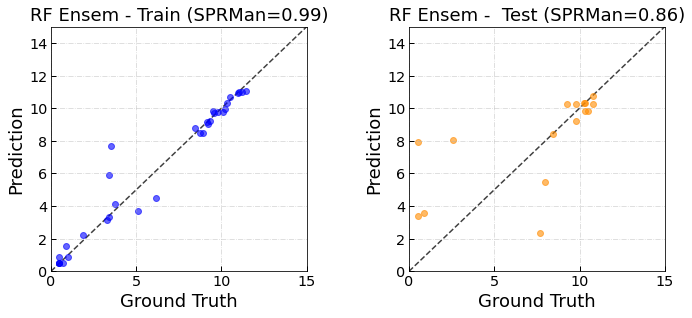

In [36]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['RF Ensem - Train','RF Ensem -  Test'],
                 ['blue', 'darkorange'])

### Finding the Global Maximum 

1. Train a regression model with all the data

In [37]:
from sklearn.model_selection import train_test_split
## Train with all the data available before optimization 
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size = 0.01)

def regr_pred(regr_list, X):
    y_regr_pred = []
    i = 0
    for regr in regr_list:
        y_regr_pred.append(scalerY.inverse_transform(regr(X).reshape(-1,1)).ravel())
    return np.array(y_regr_pred)

def gpy_regr_predict(X, gpy_regr = gpy_regr):
    yc_pred, yc_uncer= gpy_regr.predict(X)
    return yc_pred.ravel()

regr_list = [NN_regr.predict, gb_regr.predict, rf_regr.predict, gpy_regr_predict]
rfr_reg_all = RandomForestRegressor(n_estimators=100, max_depth = 5)
rfr_reg_all.fit(np.transpose(regr_pred(regr_list, X_train)), y_train.ravel())
y_pred_train = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, X_train)))
y_pred_test = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, X_test)))

y_train_org = scalerY.inverse_transform(y_train.reshape(-1,1))
y_test_org = scalerY.inverse_transform(y_test.reshape(-1,1))
y_pred_train_org = scalerY.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = scalerY.inverse_transform(y_pred_test.reshape(-1,1))

RF Ensem - Train RMSE: 0.938
RF Ensem - Train MAE: 0.446
RF Ensem - Train MAPE: 0.152
RF Ensem - Train spearman coeff.: 0.988
RF Ensem -  Test RMSE: 2.423
RF Ensem -  Test MAE: 2.423
RF Ensem -  Test MAPE: 0.732
RF Ensem -  Test spearman coeff.: nan


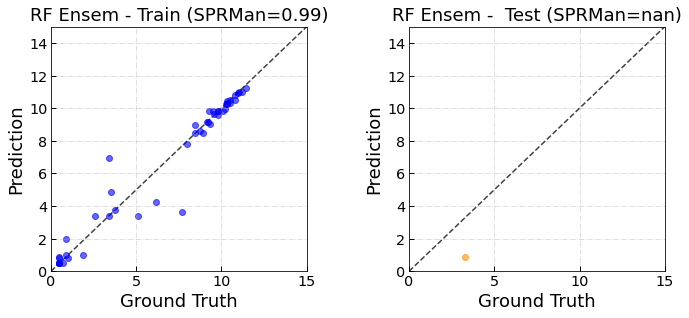

In [38]:
plt_true_vs_pred([y_train_org, y_test_org], 
                 [y_pred_train_org, y_pred_test_org], 
                 ['RF Ensem - Train','RF Ensem -  Test'],
                 ['blue', 'darkorange'])

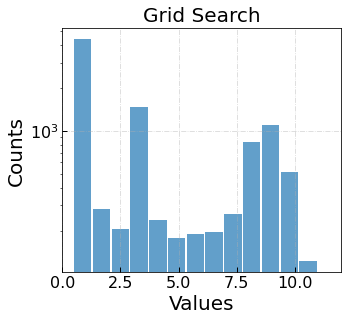

y_opt =  11.0
X_opt =  [  1.38 166.67 280.    23.  ]


In [39]:
## Creating grid sampled X
X_sampled = []
for x1 in np.linspace(0,1,10):
    for x2 in np.linspace(0,1,10):
        for x3 in np.linspace(0,1,10):
            for x4 in np.linspace(0,1,10):
                         X_sampled.append([x1,x2,x3,x4])
X_sampled = np.array(X_sampled)

y_pred_sampled = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, X_sampled)))
y_pred_sampled_org = scalerY.inverse_transform(y_pred_sampled.reshape(-1,1))

fig, ax = plt.subplots(1, 1, figsize=(5.0, 4.5)) 
ax.hist(y_pred_sampled_org, bins =13, width = 0.75, alpha = 0.7)
ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
ax.grid(True, linestyle='-.')
ax.set_xlim(0,12)
#ax.set_ylim(1,15)
ax.set_xlabel('Values', fontsize = fs)
ax.set_ylabel('Counts', fontsize = fs)
ax.set_title('Grid Search', fontsize = fs)
ax.set_yscale('log')
ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
ax.grid(True, linestyle='-.')

plt.show()

print('y_opt = ', np.around(np.max(y_pred_sampled_org),2))
print('X_opt = ', np.around(x_denormalizer([X_sampled[np.argmax(y_pred_sampled_org)]])[0],2))

2. Use Particle Swarm Optimization (PSO) to find the maximum 

In [43]:
from pyswarm import pso
# Define bounds
# X_upper_bounds = [np.max(X[:,0]), np.max(X[:,1]), np.max(X[:,2]), np.max(X[:,3])]
# X_lower_bounds = [np.min(X[:,0]), np.min(X[:,1]), np.min(X[:,2]), np.min(X[:,3])]
X_upper_bounds = [1,1,1,1]
X_lower_bounds = [0,0,0,0]
def objective(X):
    """We want to maximize y (which means minimize -y)"""
    y_pred = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, np.array([X]))))
    y_pred_org =  scalerY.inverse_transform(y_pred.reshape(-1,1))
    return -y_pred_org

# Run PSO 5 times with some generic hyper-parameters
X_opts = []
y_opts = []
n_runs = 5
for n in range(n_runs):
    print('running iteration No.', n+1)
    X_opt, _ = pso(
        objective, X_lower_bounds, X_upper_bounds,
        swarmsize=100, maxiter=100)
    X_opts.append(X_opt)
    y_opt = -objective(X_opt)
    y_opts.append(y_opt)
    print('optimized y: ', y_opt[0][0])
X_opts = np.asarray(X_opts)
y_opts = np.asarray(y_opts)
y_opt = np.max(y_opts)
X_opt = x_denormalizer([X_opts[np.argmax(y_opts)]])[0]

print('y_opt = ', np.around(y_opt,2))
print('X_opt = ', np.around(X_opt,2))

running iteration No. 1
Stopping search: maximum iterations reached --> 100
optimized y:  11.179400000000001
running iteration No. 2
Stopping search: maximum iterations reached --> 100
optimized y:  11.179400000000001
running iteration No. 3
Stopping search: maximum iterations reached --> 100
optimized y:  11.179400000000001
running iteration No. 4
Stopping search: maximum iterations reached --> 100
optimized y:  11.179400000000001
running iteration No. 5
Stopping search: maximum iterations reached --> 100
optimized y:  11.179400000000001
y_opt =  11.18
X_opt =  [  1.4  172.09 291.41  21.8 ]


###  Two-varible contour map (with randomly sampling in the other two variables)
###### Use the final ensembled regressor

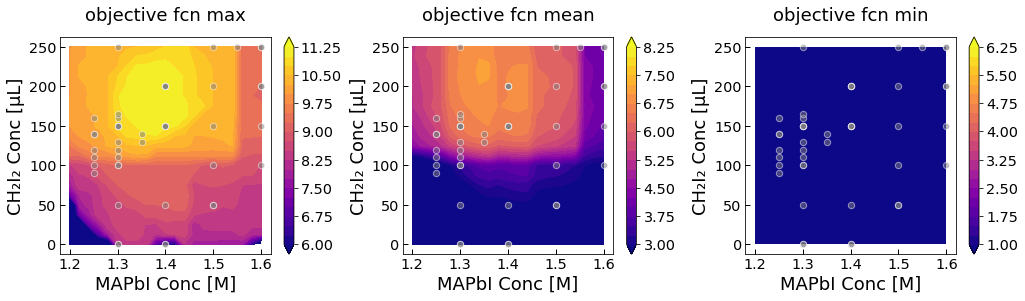

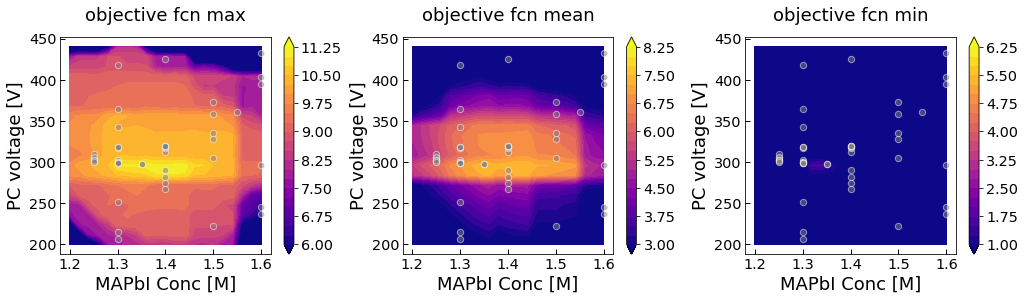

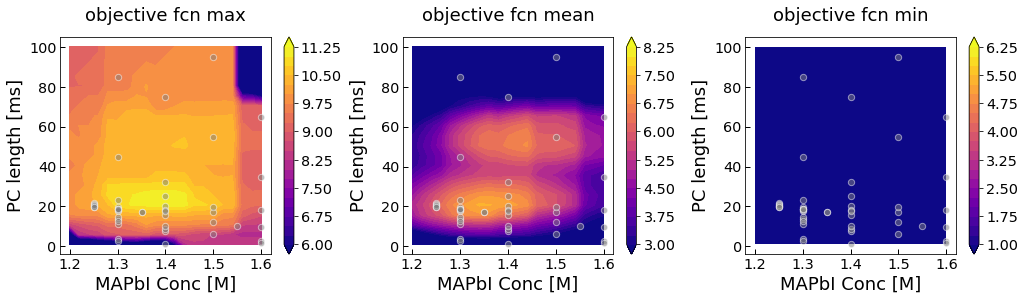

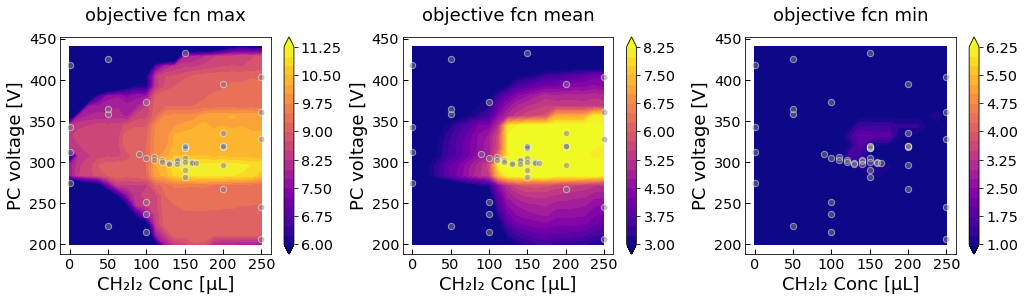

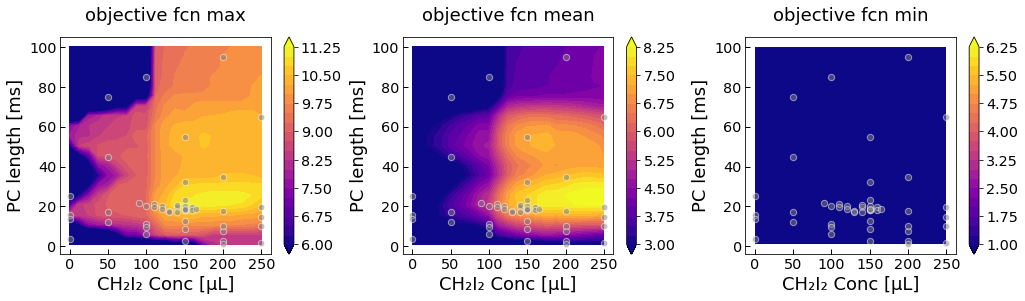

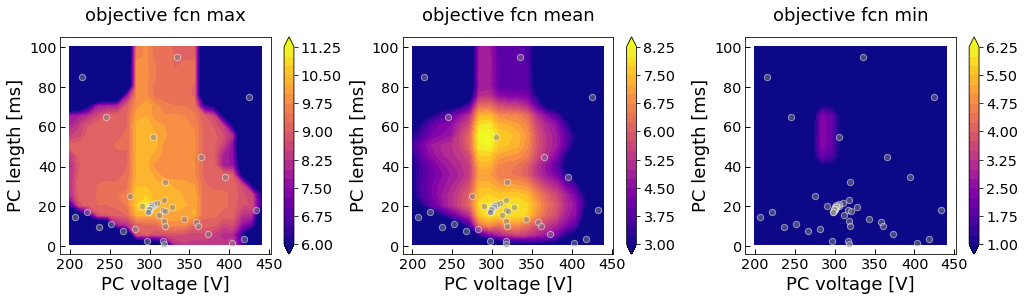

In [44]:
### Partial Dependence Plot 
def obj_predictor(X):
    y_pred = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, np.array(X))))
    y_pred_org =  scalerY.inverse_transform(y_pred.reshape(-1,1))
    return y_pred_org

design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:4].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred = obj_predictor(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [6, 3, 1]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):#[y_pred_max, y_pred_mean, y_pred_min]
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(22)*0.25+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')

#             ax.scatter(df_Xnew.values[:, ind1], 
#                        df_Xnew.values[:, ind2], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MAPbI3
                ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6])
            if ind1==1:#CH2I2
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()


  0%|          | 0/48 [00:00<?, ?it/s]

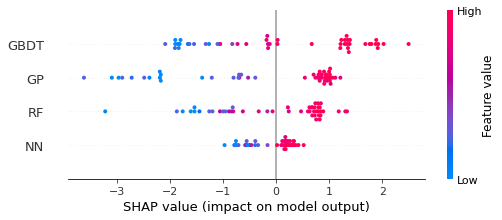

In [41]:
import shap
y_pred_indv = np.transpose(regr_pred(regr_list, np.array(X)))
#def obj_predictor_shap_model(y_pred_indv):
def obj_predictor(y_pred_indv):
    y_pred = rfr_reg_all.predict(y_pred_indv)
    y_pred_org =  scalerY.inverse_transform(y_pred.reshape(-1,1))
    return y_pred_org

model_predict = obj_predictor
df_y_pred = pd.DataFrame(y_pred_indv,
                    columns = ["NN",
                               "GBDT",
                               "RF", 
                               "GP"])

explainer = shap.KernelExplainer(obj_predictor_shap_model,shap.kmeans(df_y_pred, 10))
shap_values = explainer.shap_values(df_y_pred, nsamples=100)[0]
shap.summary_plot(shap_values, df_y_pred)
#shap.plots.bar(explainer)

  0%|          | 0/48 [00:00<?, ?it/s]

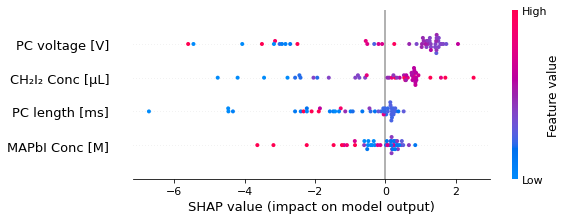

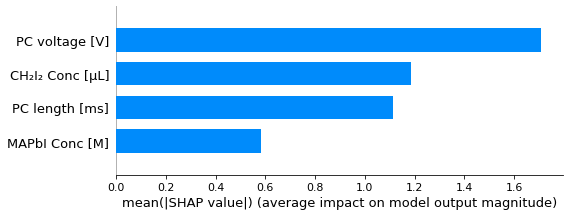

In [48]:
import shap
def obj_predictor_shap(X_org):
    X = x_normalizer(X_org)
    y_pred = rfr_reg_all.predict(np.transpose(regr_pred(regr_list, np.array(X))))
    y_pred_org =  scalerY.inverse_transform(y_pred.reshape(-1,1))
    return y_pred_org

model_predict = obj_predictor_shap
df_X = pd.DataFrame(x_denormalizer(X),
                    columns = ["MAPbI Conc [M]",
                               "CH₂I₂ Conc [μL]",
                               "PC voltage [V]", 
                               "PC length [ms]"])

explainer = shap.KernelExplainer(model_predict,shap.kmeans(df_X, 10))
shap_values = explainer.shap_values(df_X, nsamples=100)[0]
shap.summary_plot(shap_values, df_X, axis_color='black')
#print(shap_values)
shap.summary_plot(shap_values, df_X, axis_color='black',plot_type ="bar")

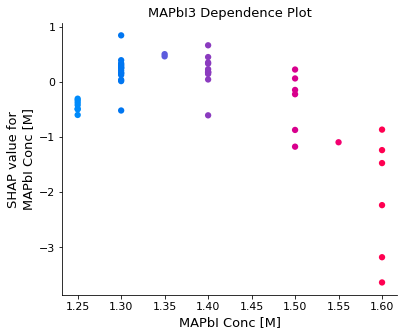

In [49]:
shap.dependence_plot(0,shap_values,df_X, 
                     interaction_index=0, 
                     dot_size=40,
                     axis_color='black',
                     title='MAPbI3 Dependence Plot')

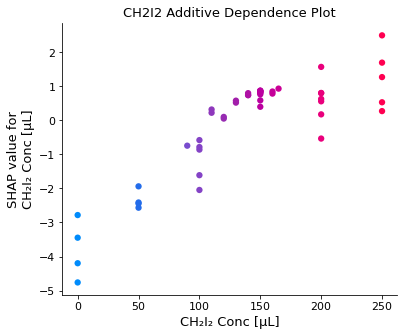

In [50]:
shap.dependence_plot(1,shap_values,df_X,
                     interaction_index=1,
                     dot_size=40,
                     axis_color='black',
                     title='CH2I2 Additive Dependence Plot')

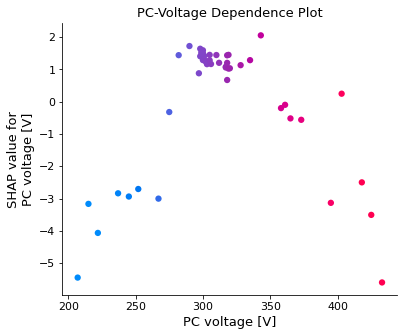

In [51]:
shap.dependence_plot(2,shap_values,df_X,
                     interaction_index=2, 
                     dot_size=40,
                     axis_color='black',
                     title='PC-Voltage Dependence Plot')

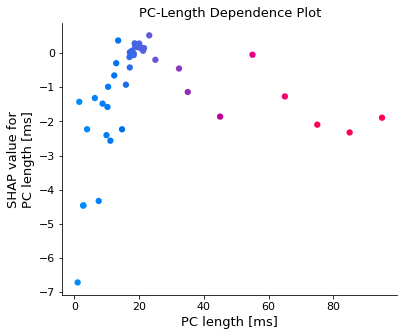

In [52]:
shap.dependence_plot(3,shap_values,df_X,
                     interaction_index=3, 
                     dot_size=40,
                     axis_color='black',
                     title='PC-Length Dependence Plot')